# Quadcopter Sim

References:

- https://charlestytler.com/modeling-vehicle-dynamics-6dof-nonlinear-simulation/


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from pyrk import RK4
from scipy.optimize import fsolve
from math import sqrt, pi

%matplotlib inline

In [16]:
# Physical Constants
m = 0.1         #kg
Ixx = 0.00062   #kg-m^2
Iyy = 0.00113   #kg-m^2
Izz = 0.9*(Ixx + Iyy) #kg-m^2 (Assume nearly flat object, z=0)
dx = 0.114      #m
dy = 0.0825     #m
g = 9.81  #m/s/s
DTR = 1/57.3; RTD = 57.3

In [10]:
# Propeller Thrust equations as a function of propeller induced velocity, vi
def thrustEqn(vi, *prop_params):
    
    # Unpack parameters
    R,A,rho,a,b,c,eta,theta0,theta1,U,V,W,Omega = prop_params
    
    # Calculate local airflow velocity at propeller with vi, V'
    Vprime = np.sqrt(U**2 + V**2 + (W - vi)**2)
    
    # Calculate Thrust averaged over one revolution of propeller using vi
    Thrust = 1/4 * rho * a * b * c * R * \
        ( (W - vi) * Omega * R + 2/3 * (Omega * R)**2 * (theta0 + 3/4 * theta1) + \
          (U**2 + V**2) * (theta0 + 1/2 * theta1) )
    
    # Calculate residual for equation: Thrust = mass flow rate * delta Velocity
    residual = eta * 2 * vi * rho * A * Vprime - Thrust
    
    return residual

    
def Fthrust(x, u, dx, dy):
    # Inputs: Current state x[k], Commanded Propeller RPM inputs u[k],
    #         Propeller location distances dx, dy (m)
    # Returns: Thrust vector for 4 propellers (Newtons)
    
    # Propeller Configuration parameters
    
    R = 0.0762   # propeller length/ disk radius (m) 
    A = np.pi * R ** 2
    rho = 1.225  #kg/m^3  at MSL
    a = 5.7      # Lift curve slope used in example in Stevens & Lewis
    b = 2        # number of blades
    c = 0.0274   # mean chord length (m)
    eta = 1      # propeller efficiency
    
    # Manufacturer propeller length x pitch specification:
    p_diameter = 6  #inches
    p_pitch = 3   #inches
    
    theta0 = 2*np.arctan2(p_pitch, (2 * np.pi * 3/4 * p_diameter/2))
    theta1 = -4 / 3 * np.arctan2(p_pitch, 2 * np.pi * 3/4 * p_diameter/2)
    
    
    # Local velocity at propeller from vehicle state information
    ub, vb, wb = x[0], x[1], x[2]
    p, q, r = x[3], x[4], x[5]
    # Transofrm velocity to local propeller location:
    #     [U,V,W] = [ub,vb,wb] + [p,q,r] x [dx,dy,0]
    U = ub - r * dy
    V = vb + r * dx
    W = wb - q * dx + p * dy
    
    # Convert commanded RPM to rad/s
    Omega = 2 * np.pi / 60 * u
    
    #Collect propeller config, state, and input parameters
    prop_params = (R,A,rho,a,b,c,eta,theta0,theta1,U,V,W,Omega)
    
    # Numerically solve for propeller induced velocity, vi
    # using nonlinear root finder, fsolve, and prop_params
    vi0 = 0.1    # initial guess for vi
    vi = fsolve(thrustEqn, vi0, args=prop_params)
    
    # Plug vi back into Thrust equation to solve for T
    Vprime = np.sqrt(U**2 + V**2 + (W - vi)**2)
    Thrust = eta * 2 * vi * rho * A * Vprime
    
    return Thrust

    
# Torque function
def T(F,dx,dy):
    # Returns torque about cg given thrust force and dx,dy distance from cg
    
    #### PLACEHOLDER ####
    return 0

In [23]:
rk = RK4(quadcopter2)
# y = np.array([0,1])
y = np.zeros(12)
t = 0.0
step = 0.02
ierr = 0
last_err = 0

yi = []
ti = []

goal = 4

for i in range(int(30/step)):
    u = controlInputs(y, t)
    
    y = rk.step(y,u,t,step)
    t += step
    
    ti.append(t)
    yi.append(y)

# v = [x[:3] for x in yi] # velocity
# p = [x[3:6] for x in yi] # position

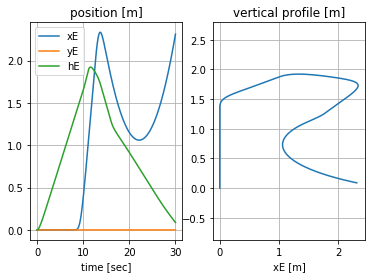

In [60]:
xe = [x[9] for x in yi] # position
ye = [x[10] for x in yi] # position
he = [x[11] for x in yi] # position

plt.subplot(1,2,1)
plt.plot(ti,xe,label="xE")
plt.plot(ti,ye,label="yE")
plt.plot(ti,he,label="hE")
plt.title('position [m]')
plt.xlabel('time [sec]')
plt.legend()
# plt.axis('equal')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(xe,he)
plt.title('vertical profile [m]')
plt.xlabel('xE [m]')
plt.axis('equal')
plt.grid(True)

plt.show()

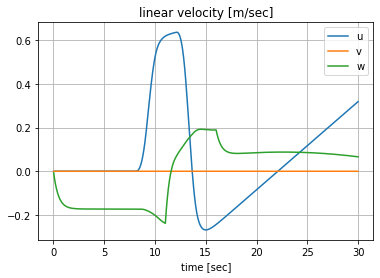

In [52]:
u = [x[0] for x in yi] # position
v = [x[1] for x in yi] # position
w = [x[2] for x in yi] # position

plt.plot(ti,u,label="u")
plt.plot(ti,v,label="v")
plt.plot(ti,w,label="w")
plt.title('linear velocity [m/sec]')
plt.xlabel('time [sec]')
plt.legend()
# plt.axis('equal')
plt.grid(True)

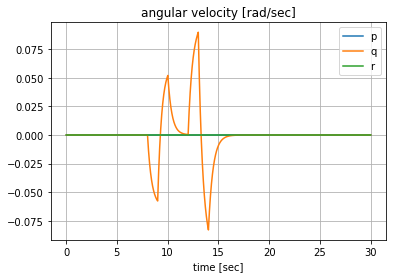

In [53]:
p = [x[3] for x in yi] # position
q = [x[4] for x in yi] # position
r = [x[5] for x in yi] # position

plt.plot(ti,p,label="p")
plt.plot(ti,q,label="q")
plt.plot(ti,r,label="r")
plt.title('angular velocity [rad/sec]')
plt.xlabel('time [sec]')
plt.legend()
# plt.axis('equal')
plt.grid(True)

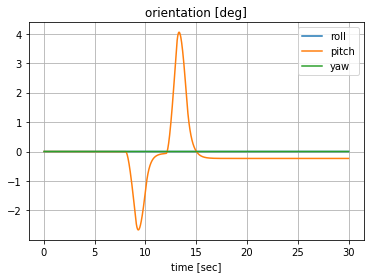

In [58]:
r = [x[6]*180/pi for x in yi] # position
p = [x[7]*180/pi for x in yi] # position
y = [x[8]*180/pi for x in yi] # position

plt.plot(ti,r,label="roll")
plt.plot(ti,p,label="pitch")
plt.plot(ti,y,label="yaw")
plt.title('orientation [deg]')
plt.xlabel('time [sec]')
plt.legend()
# plt.axis('equal')
plt.grid(True)

- $[u,v,w]$: body linear velocity (m/sec)
- $[p,q,s]$: body angular velocity (rads/sec)
- $[\phi,\theta,\psi]$: Euler angles (roll, pitch, yaw) (deg)
- $[x,y,z]^E$: Navigation (world) coordinates (m)
- $[F_1, F_2,F_3,F_4]$: propeller motor forces (N)
- $[L,M,N]$: Torques (N/m)

In [7]:
# Nonlinear Dynamics Equations of Motion
def quadcopter2(t,x,u):
    # Inputs: state vector (x), input vector (u)
    # Returns: time derivative of state vector (xdot)
    
    #  State Vector Reference:
    # idx  0, 1, 2, 3, 4, 5,  6,   7,   8,   9, 10, 11
    # x = [u, v, w, p, q, r, phi, the, psi, xE, yE, hE]
    
    # Store state variables in a readable format
    ub = x[0]
    vb = x[1]
    wb = x[2]
    p = x[3]
    q = x[4]
    r = x[5]
    phi = x[6]
    theta = x[7]
    psi = x[8]
    xE = x[9]
    yE = x[10]
    hE = x[11]
    
    # Calculate forces from propeller inputs (u)
    F1 = Fthrust(x, u[0],  dx,  dy)
    F2 = Fthrust(x, u[1], -dx, -dy)
    F3 = Fthrust(x, u[2],  dx, -dy)
    F4 = Fthrust(x, u[3], -dx,  dy)
    Fz = F1 + F2 + F3 + F4
    L = (F2 + F3) * dy - (F1 + F4) * dy
    M = (F1 + F3) * dx - (F2 + F4) * dx
    N = -T(F1,dx,dy) - T(F2,dx,dy) + T(F3,dx,dy) + T(F4,dx,dy)
    
    # Pre-calculate trig values
    cphi = np.cos(phi);   sphi = np.sin(phi)
    cthe = np.cos(theta); sthe = np.sin(theta)
    cpsi = np.cos(psi);   spsi = np.sin(psi)
    
    # Calculate the derivative of the state matrix using EOM
    xdot = np.zeros(12)
    
    xdot[0] = -g * sthe + r * vb - q * wb  # = udot
    xdot[1] = g * sphi*cthe - r * ub + p * wb # = vdot
    xdot[2] = 1/m * (-Fz) + g*cphi*cthe + q * ub - p * vb # = wdot
    xdot[3] = 1/Ixx * (L + (Iyy - Izz) * q * r)  # = pdot
    xdot[4] = 1/Iyy * (M + (Izz - Ixx) * p * r)  # = qdot
    xdot[5] = 1/Izz * (N + (Ixx - Iyy) * p * q)  # = rdot
    xdot[6] = p + (q*sphi + r*cphi) * sthe / cthe  # = phidot
    xdot[7] = q * cphi - r * sphi  # = thetadot
    xdot[8] = (q * sphi + r * cphi) / cthe  # = psidot
    
    xdot[9] = cthe*cpsi*ub + (-cphi*spsi + sphi*sthe*cpsi) * vb + \
        (sphi*spsi+cphi*sthe*cpsi) * wb  # = xEdot
        
    xdot[10] = cthe*spsi * ub + (cphi*cpsi+sphi*sthe*spsi) * vb + \
        (-sphi*cpsi+cphi*sthe*spsi) * wb # = yEdot
        
    xdot[11] = -1*(-sthe * ub + sphi*cthe * vb + cphi*cthe * wb) # = hEdot
    
    return xdot

In [9]:
def controlInputs(x, t):
    # Inputs: Current state x[k], time t
    # Returns: Control inputs u[k]
    
    #### Placeholder Function ####
    
    # Trim RPM for all 4 propellers to provide thrust for a level hover
    trim = 3200
    
    pitch_cmd = 0
    roll_cmd = 0
    climb_cmd = 0
    yaw_cmd = 0
    
    # Example open loop control inputs to test dynamics:
    #  Climb
    if t < 11.0:
        climb_cmd = 500
    
    #  Pitch Forward
    if t > 8.0:
        pitch_cmd = -10
    if t > 9.0:
        pitch_cmd = 10
    if t > 10.0:
        pitch_cmd = 0
    
    #  Pitch Backward
    if t > 12.0:
        pitch_cmd = 15
    if t > 13.0:
        pitch_cmd = -15
    if t > 14.0:
        pitch_cmd = 0
    
    #  Increase lift
    if t > 16.0:
        climb_cmd = 150
        
    
    # RPM command based on pitch, roll, climb, yaw commands
    u = np.zeros(4)
    u[0] = trim + ( pitch_cmd + roll_cmd + climb_cmd - yaw_cmd) / 4
    u[1] = trim + (-pitch_cmd - roll_cmd + climb_cmd - yaw_cmd) / 4
    u[2] = trim + ( pitch_cmd - roll_cmd + climb_cmd + yaw_cmd) / 4
    u[3] = trim + (-pitch_cmd + roll_cmd + climb_cmd + yaw_cmd) / 4
    
    
    return u